In [1]:
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split

In [2]:
!which python

/Users/ryansun2/miniforge3/envs/analytics5/bin/python


In [4]:
import tensorflow as tf
print(tf.__version__)

2.4.0-rc0


In [5]:
import numpy as np
np.version.version

'1.19.5'

In [ ]:
# !python - version

In [6]:
glove_embeddings = dict()
f = open('glove/glove.twitter.27B.25d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs
f.close()

In [7]:
glove_embeddings['<user>']

array([ 0.62415 ,  0.62476 , -0.082335,  0.20101 , -0.13741 , -0.11431 ,
        0.77909 ,  2.6356  , -0.46351 ,  0.57465 , -0.024888, -0.015466,
       -2.9696  , -0.49876 ,  0.095034, -0.94879 , -0.017336, -0.86349 ,
       -1.3348  ,  0.046811,  0.36999 , -0.57663 , -0.48469 ,  0.40078 ,
        0.75345 ], dtype=float32)

# try RNN

In [10]:
df = pd.read_csv('train.csv', dtype =object,  usecols= ['id', 'text', 'target'])
df['target'] = df['target'].astype(float)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=10)
# target = df.pop('target')

In [11]:
vocab_size = 10000
embedding_dim = 25

max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(df_train['text'])
word_index = tokenizer.word_index

# use index method 

training_sequences = tokenizer.texts_to_sequences(df_train['text'])
training_padded = pad_sequences(training_sequences, maxlen=max_length, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(df_test['text'])
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

# this still may be converted to a vectorization layer

In [9]:
# for word, index in tokenizer.word_index.items():
#     print(word + ' ' + str(index))
# len(tokenizer.word_index)
# tokenizer.word_counts['t']

In [12]:
# embedding_matrix is a numpy array, where the row index represents the token index
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [13]:
# look for the coverage
xs=[]
ys=[]
cumulative_x=[]
cumulative_y=[]
total_y=0
for word, index in tokenizer.word_index.items():
  xs.append(index)
  cumulative_x.append(index)
  if glove_embeddings.get(word) is not None:
    total_y = total_y + 1
    ys.append(1)
  else:
    ys.append(0)
  cumulative_y.append(total_y / index)

In [14]:
len(cumulative_y)


19479

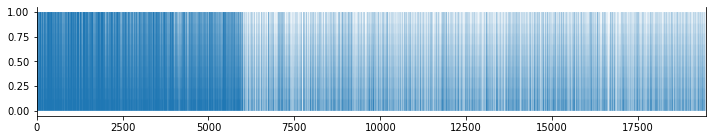

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,2))
ax.spines['top'].set_visible(False)

plt.margins(x=0, y=None, tight=True)
#plt.axis([13000, 14000, 0, 1])
plt.fill(ys)

[0.5704604959186816]


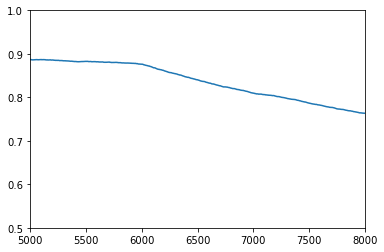

In [16]:
import matplotlib.pyplot as plt
plt.plot(cumulative_x, cumulative_y)
plt.axis([5000, 8000 , 0.5, 1])
print(cumulative_y[-1:])

# for now, just use 6000

In [17]:
training_padded

array([[   0,    0,    0, ...,   21, 1169, 2065],
       [   0,    0,    0, ...,    3, 6010, 6011],
       [   0,    0,    0, ...,    2,    3, 6012],
       ...,
       [   0,    0,    0, ...,  987,  938, 1049],
       [   0,    0,    0, ...,    2,    3,    1],
       [   0,    0,    0, ...,    2,    3,    1]], dtype=int32)

In [18]:
print('embedding_dim:' +  str(embedding_dim))
print('embedding_dim:' +  str(max_length))

embedding_dim:25
embedding_dim:120


In [17]:
# model=tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim),
#     tf.keras.layers.LSTM(embedding_dim),
# #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    
#     tf.keras.layers.Dense(24, activation ='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])


In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
#     tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True, dropout=0.4)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.4)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# optimizer = tf.keras.optimizers.Adam(lr=0.0007)
optimizer = tf.keras.optimizers.Adam(lr=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=False)
# what is the beta_1 and beta_2? 

# optimizer = tf.keras.optimizers.Adam(lr=0.00001)
model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.Precision(), 
                                                                   tf.keras.metrics.Recall()])
model.summary()

# how to add in precision and recall? 


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 25)          250000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 50)          10200     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50)                15200     
_________________________________________________________________
dense (Dense)                (None, 6)                 306       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 275,713
Trainable params: 25,713
Non-trainable params: 250,000
_________________________________________________________________


In [20]:
num_epochs = 50
history = model.fit(training_padded, df_train['target'], epochs=num_epochs, validation_data=(testing_padded, df_test['target']),
                   callbacks=[callback])

Epoch 1/50
191/191 [==============================] - 37s 181ms/step - loss: 0.6241 - accuracy: 0.6492 - precision: 0.6950 - recall: 0.2701 - val_loss: 0.4856 - val_accuracy: 0.7787 - val_precision: 0.8072 - val_recall: 0.6450
Epoch 2/50
191/191 [==============================] - 33s 174ms/step - loss: 0.5020 - accuracy: 0.7706 - precision: 0.7786 - recall: 0.6492 - val_loss: 0.4667 - val_accuracy: 0.7892 - val_precision: 0.7846 - val_recall: 0.7100
Epoch 3/50
191/191 [==============================] - 33s 175ms/step - loss: 0.4900 - accuracy: 0.7797 - precision: 0.7706 - recall: 0.6860 - val_loss: 0.4651 - val_accuracy: 0.7932 - val_precision: 0.7849 - val_recall: 0.7221
Epoch 4/50
191/191 [==============================] - 34s 180ms/step - loss: 0.4755 - accuracy: 0.7782 - precision: 0.7771 - recall: 0.6623 - val_loss: 0.4626 - val_accuracy: 0.7892 - val_precision: 0.8175 - val_recall: 0.6631
Epoch 5/50
191/191 [==============================] - 34s 180ms/step - loss: 0.4674 - accura

KeyboardInterrupt: 

In [ ]:
# continue from here 

In [ ]:
test_target_pred = (model.predict(testing_padded) > 0.5).astype(int)
# test_target_pred_class = model.predict_classes(testing_padded)

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

print('accuracy: ' + str(accuracy_score(y_pred=test_target_pred, y_true=df_test['target'])))
print('precision: ' +  str(precision_score(y_pred=test_target_pred, y_true=df_test['target'])))
print('recall: ' + str(recall_score(y_pred=test_target_pred, y_true=df_test['target'])))
print('f1: ' +  str(f1_score(y_pred=test_target_pred, y_true=df_test['target'])))
print('auc: ' +  str(roc_auc_score(y_score=test_target_pred, y_true=df_test['target'])))


In [ ]:
model.metrics_names

In [ ]:
loss, accuracy, precision, recall = model.evaluate(x=testing_padded, y = df_test['target'])

print("Loss: ", loss)
print("Accuracy: ", accuracy)
print('precision: ', precision)
print('recall: ', recall)


In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
import matplotlib.pyplot as plt
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
# for ele, text in ds_test_raw.take(-1):
#     print(ele)

# t = ds_test_raw.map(lambda x, y: x.numpy())